<a href="https://colab.research.google.com/github/lIlIlIIIlIIl/Toy_Project/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir results

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

# Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 170498071/170498071 [00:04<00:00, 35345336.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Code

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, model_code, in_channels, kernel_size, stride, out_dim, hid_dim, n_linear, act_func, use_bn, dropout):
        super(CNN, self).__init__()
        self.model_code = model_code
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.act_func = act_func
        self.use_bn = use_bn
        self.n_linear = n_linear
        self.Dropout = nn.Dropout(dropout)
        self.padding = self.kernel_size // 2


        if (32 - self.kernel_size + 2*self.padding)/self.stride + 1 != 32:
            raise ValueError('filter is not valid')


        if self.act_func == 'relu':
            self.act_func = nn.ReLU()

        elif self.act_func == 'tanh':
            self.act_func = nn.Tanh()

        elif self.act_func == 'sigmoid':
            self.act_func = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        self.layers = self._make_layers()
        self.classifier = self._make_fc_layers()

    def _make_layers(self):
        layers = [] # Sequential을 사용하기 위해 ModuleList가 아닌 그냥 List 사용
        for x in cfg[self.model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(2, 2)]

            else:
                layers += [nn.Conv2d(self.in_channels, x, self.kernel_size, self.stride, self.padding)]
                if self.use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act_func]
                self.in_channels = x # in_channels 업데이트

        return nn.Sequential(*layers)
        # *layers: layers 리스트의 데이터들을 각각 받아주는 문법(가변 인수 느낌)
        # Sequential은 리스트를 받아서 하나의 서브모델을 만들어주는 문법. CNN모델 내의 layers모델을 서브모델로 만듦

    def _make_fc_layers(self):
        linears = []
        linears.append(nn.Linear(512, self.hid_dim))
        for i in range(self.n_linear - 2):
            linears += [self.act_func, nn.Linear(self.hid_dim, self.hid_dim),self.Dropout]

        linears += [self.act_func, nn.Linear(self.hid_dim, self.out_dim),self.Dropout]
        return nn.Sequential(*linears)


    def forward(self, x):
        x = self.layers(x) # layers가 하나의 서브모델
        x = x.view(x.size(0), -1) # batch size는 그대로 유지하면서 3차원 tensor를 벡터 형태로 펼쳐준다.
        x = self.classifier(x)

        return x

# Dimenstion Check

In [ ]:
def dimension_check():
    net = CNN('VGG11', 3, 7, 1, 10, 4096, 3,'relu', True, 0)
    x = torch.randn(2, 3, 32, 32) # 해당 크기를 갖는 임의의 텐서를 생성
    y = net(x)
    print(y.size())

# layer를 쌓을 때마다 dimension이 맞는지 체크해주는 함수

dimension_check()

torch.Size([2, 10])


# Train

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        # get the inputs
        inputs, labels = data
        # print(inputs.size()) => (batchsize, channel, H, W) = (256, 3, 32, 32). 즉 dataloader가 4차원 텐서 형태로 데이터를 받아놓음; (shape쓰면 안됨)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# Validation

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# Test

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

# Experiment

In [ ]:
def experiment(partition, args):

    net = CNN(args.model_code, args.in_channels, args.kernel_size, args.stride, args.out_dim, args.hid_dim, args.n_linear ,args.act_func, args.use_bn, args.dropout)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Load, Save EXP

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Visualize

In [ ]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# Execute

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp8"

# ====== Model Capacity ====== #
args.out_dim = 10
args.hid_dim = 512
args.n_linear = 2
args.act_func = 'relu'
args.model_code = 'VGG13'
args.in_channels = 3
args.kernel_size = 3
args.stride = 1

# ====== Regularization ======= #
args.l2 = 0.0001
args.use_bn = True
args.dropout = 0.3

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 15

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'act_func'
name_var2 = 'optim'
list_var1 = ['relu', 'tanh', 'sigmoid']
list_var2 = ['SGD', 'RMSprop', 'Adam']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp8', out_dim=10, hid_dim=512, n_linear=2, act_func='relu', model_code='VGG13', in_channels=3, kernel_size=3, stride=1, l2=0.0001, use_bn=True, dropout=0.3, optim='SGD', lr=0.001, epoch=15, train_batch_size=512, test_batch_size=1024)
Epoch 0, Acc(train/val): 19.71/27.80, Loss(train/val) 2.21/2.12. Took 17.03 sec
Epoch 1, Acc(train/val): 29.13/34.68, Loss(train/val) 2.06/1.98. Took 17.72 sec
Epoch 2, Acc(train/val): 32.57/38.51, Loss(train/val) 1.95/1.87. Took 16.12 sec
Epoch 3, Acc(train/val): 35.17/40.97, Loss(train/val) 1.87/1.78. Took 16.28 sec
Epoch 4, Acc(train/val): 37.19/43.20, Loss(train/val) 1.80/1.71. Took 16.10 sec
Epoch 5, Acc(train/val): 38.28/44.96, Loss(train/val) 1.76/1.65. Took 16.11 sec
Epoch 6, Acc(train/val): 39.84/46.25, Loss(train/val) 1.71/1.60. Took 16.27 sec
Epoch 7, Acc(train/val): 40.77/47.82, Loss(train/val) 1.67/1.56. Took 17.59 sec
Epoch 8, Acc(train/val): 42.18/49.22, Loss(train/val) 1.63/1.52. Took 15.87 sec
Epoch 9, Acc(train/val): 

# Plot

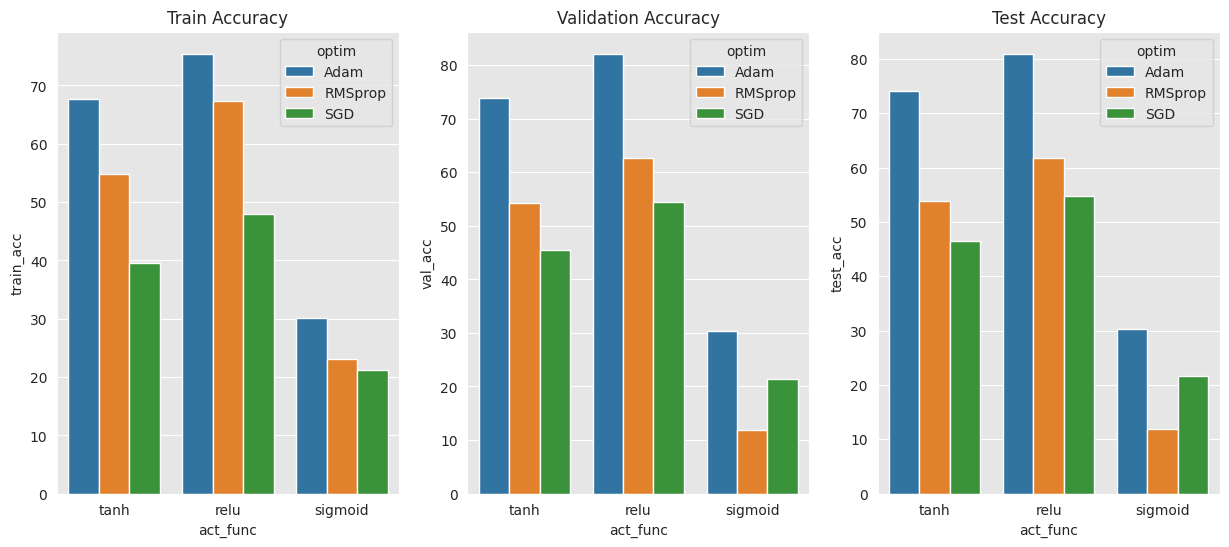

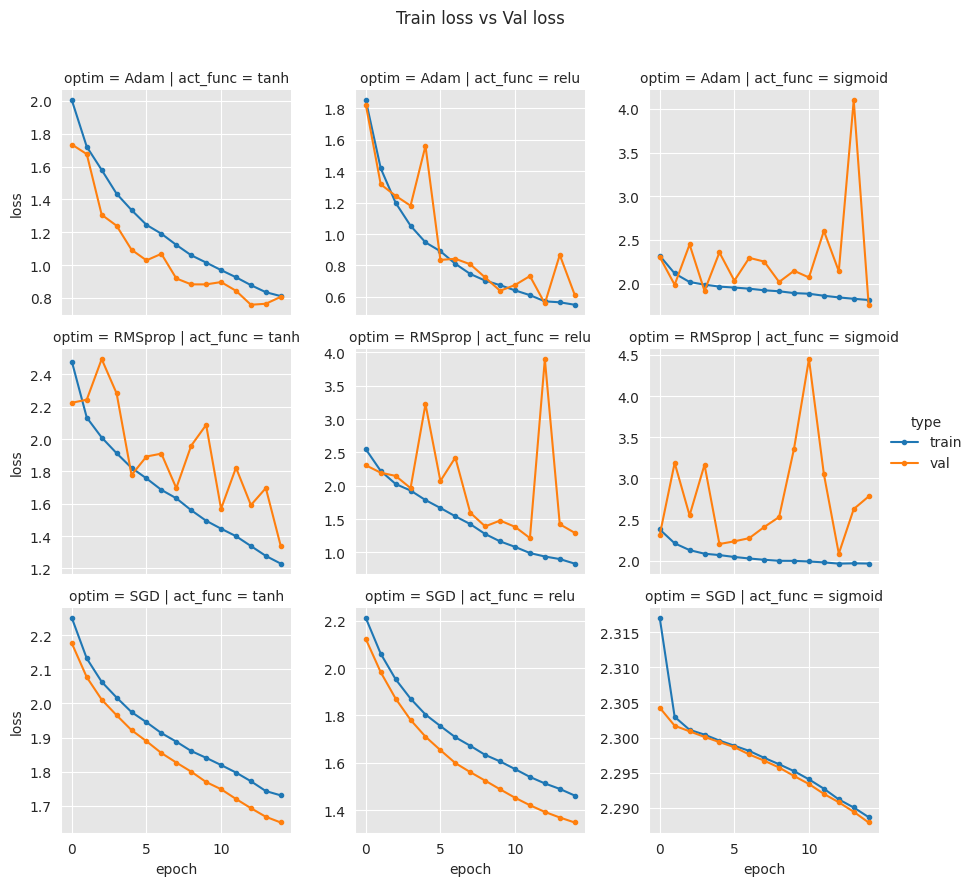

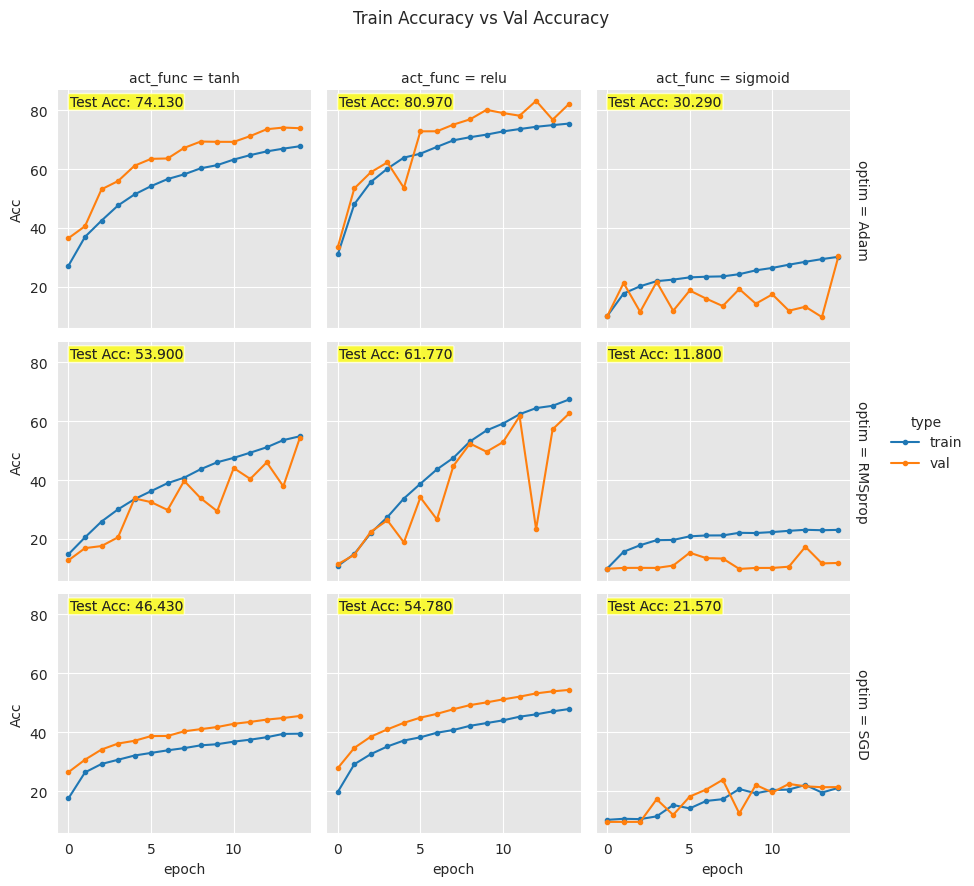

In [ ]:
var1 = 'act_func'
var2 = 'optim'
df = load_exp_result('exp8')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.